In [1]:
import datetime

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geocoder
import Geohash

%matplotlib inline

/Users/rycpt/.virtualenvs/taxi/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
def geohash_placename(placename='The Metropolitan Museum of Art', precision=6):
    latlng = geocoder.google(placename).latlng
    return Geohash.encode(latlng[0], latlng[1])[:precision]

'dr5ruz'

dr5rvn 79th and York
dr5re. New York Stock Exchange
Requesting query... ok.
Query running...
Query done.
Processed: 20.0 Gb

Retrieving results...
  Got page: 1; 50.0% done. Elapsed 11.07 s.
  Got page: 2; 100.0% done. Elapsed 17.7 s.
  Got page: 3; 100.0% done. Elapsed 18.62 s.
Got 70084 rows.

Total time taken 20.91 s.
Finished at 2016-06-11 23:20:40.


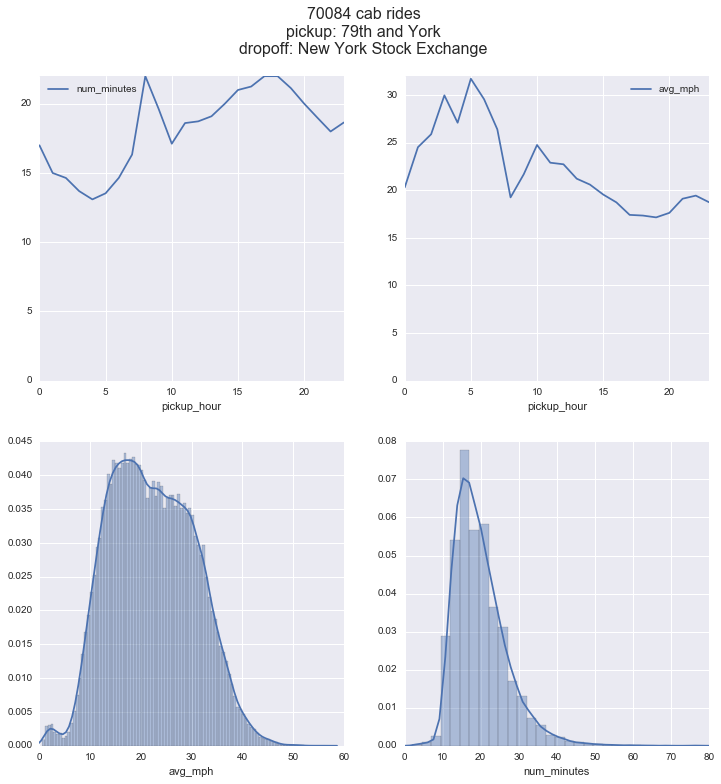

In [17]:
pickup_place = '79th and York'
dropoff_place = 'New York Stock Exchange'
# pickup_geohash = geohash_placename(pickup_place, precision=5)+'.'
# dropoff_geohash = 'dr5x[0-3].' #geohash_placename(dropoff_place, precision=5)+'.'
pickup_geohash = geohash_placename(pickup_place, precision=6)
dropoff_geohash = geohash_placename(dropoff_place, precision=5) + '.'
print pickup_geohash, pickup_place
print dropoff_geohash, dropoff_place

q = """
SELECT
  pickup_street1, pickup_street2, dropoff_street1, dropoff_street2,
  trips_medallion, trips_pickup_datetime, trips_dropoff_datetime,
  trips_avg_mph AS avg_mph,
  trips_trip_duration_hours*60.0 AS num_minutes,
  HOUR(TIMESTAMP(trips_pickup_datetime)) AS pickup_hour
FROM
  [taxi_strava.joined_geohash_geonames]
WHERE
  REGEXP_MATCH(trips_geohashed_pickup, '{0}')
  AND REGEXP_MATCH(trips_geohashed_dropoff, '{1}')
  AND trips_avg_mph < 60.0
  AND 0.0 < trips_avg_mph
  AND 0.1 < trips_trip_distance 
  AND 0.02 < trips_trip_duration_hours
""".format(pickup_geohash, dropoff_geohash)
df = pd.read_gbq(q, project_id='bigquery-reddit-1003')

fig, axarr = plt.subplots(2,2,figsize=(12,12))
df[['pickup_hour', 'num_minutes']].groupby('pickup_hour').median().plot(ax=axarr[0,0]) #.hist(column='num_hours')
axarr[0,0].set_ylim([0, axarr[0,0].get_ylim()[1]])
df[['pickup_hour', 'avg_mph']].groupby('pickup_hour').median().plot(ax=axarr[0,1]) #.hist(column='num_hours')
axarr[0,1].set_ylim([0, axarr[0,1].get_ylim()[1]])
sns.distplot(df['avg_mph'],bins=100, norm_hist=False, ax=axarr[1,0])
axarr[1,0].set_xlim([0,60])
sns.distplot(df['num_minutes'],bins=60, norm_hist=False, ax=axarr[1,1])
axarr[1,1].set_xlim([0,80])
plt.suptitle('{0} cab rides\npickup: {1}\ndropoff: {2}'.format(len(df), pickup_place, dropoff_place), size=16)

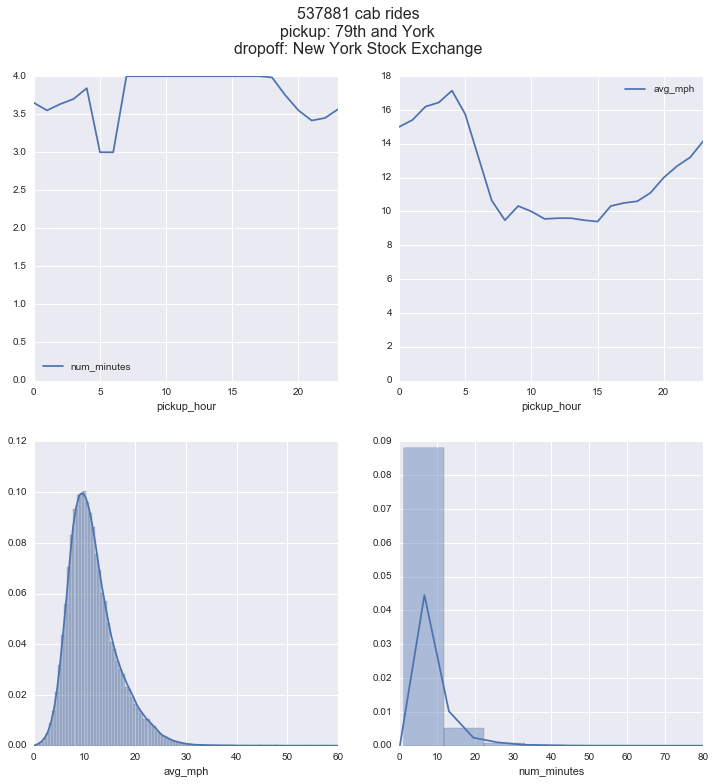

In [11]:
fig, axarr = plt.subplots(2,2,figsize=(12,12))
df[['pickup_hour', 'num_minutes']].groupby('pickup_hour').median().plot(ax=axarr[0,0]) #.hist(column='num_hours')
axarr[0,0].set_ylim([0, axarr[0,0].get_ylim()[1]])
df[['pickup_hour', 'avg_mph']].groupby('pickup_hour').median().plot(ax=axarr[0,1]) #.hist(column='num_hours')
axarr[0,1].set_ylim([0, axarr[0,1].get_ylim()[1]])
sns.distplot(df['avg_mph'],bins=100, ax=axarr[1,0])
axarr[1,0].set_xlim([0,60])
sns.distplot(df['num_minutes'],bins=60, ax=axarr[1,1])
axarr[1,1].set_xlim([0,80])
plt.suptitle('{0} cab rides\npickup: {1}\ndropoff: {2}'.format(len(df), pickup_place, dropoff_place), size=16)

In [4]:
df.head()

,pickup_street1,pickup_street2,dropoff_street1,dropoff_street2,trips_medallion,trips_pickup_datetime,trips_dropoff_datetime,avg_mph,num_minutes,pickup_hour
0,E 79th St,2nd Ave,E 79th St,2nd Ave,B83044D63E9421B76011917CE280C137,2013-08-25 02:59:00,2013-08-25 03:01:00,14.700000,2.000000,2
1,E 79th St,2nd Ave,E 79th St,2nd Ave,500B99D0D2ED7D114701456891419249,2013-09-15 10:56:00,2013-09-15 11:00:00,8.400000,4.000000,10
2,E 79th St,2nd Ave,E 79th St,2nd Ave,CBE2D853AA37439D5D74E624FB0DF46D,2013-09-15 11:35:00,2013-09-15 11:38:00,9.600000,3.000000,11
3,E 79th St,2nd Ave,E 79th St,2nd Ave,50D4C767D0A087747F3B91C398290CF6,2013-02-15 11:39:17,2013-02-15 11:40:55,7.346939,1.633333,11
4,E 79th St,2nd Ave,E 79th St,2nd Ave,8255AD96874E887517A738EC05C163CA,2013-09-14 07:43:22,2013-09-14 07:46:31,11.428571,3.150000,7


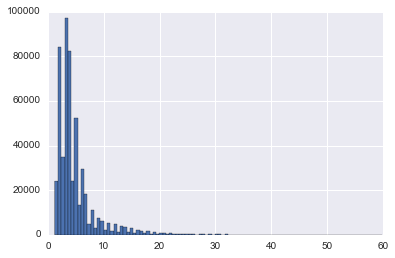

In [15]:
df[df['num_minutes']<60]['num_minutes'].hist(bins=100)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11b04d450>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x129b2e190>]], dtype=object)

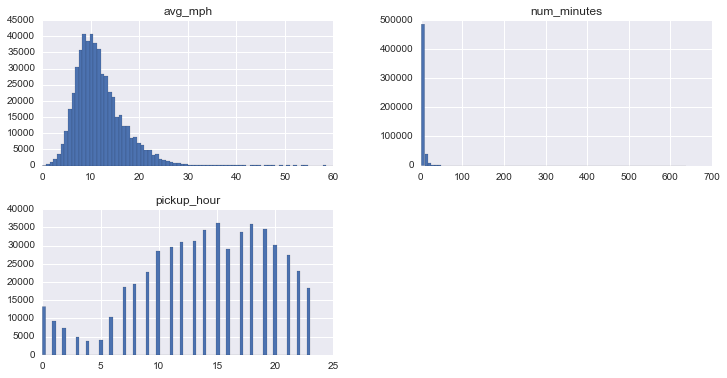

In [12]:
df.hist(bins=80, figsize=(12,6), linewidth=0.1)

In [6]:
df['trips_medallion'].value_counts()

7E1346F23960CC18D7D129FA28B63A75    315
75492634DA43822FF364AEEECF81DB9F    200
7D11B5EAD419CD87FCEAF8EFE87F5F75    199
ECF274DD2C2FB8A1398C2CF2972B8D6C    193
9D6119496EE8F286DB2B312C5ABB884B    190
478E7C31753D38896A9CAC38703F7F1D    190
3AB9079A089EE33D7FA7259B482770B4    178
52CE7B48D9569319DBE0445709AF1266    172
3A8AAB9DE0A67D0D6B0ACB1360B66696    167
B6E265A6A0CB44E7DF92FEDB77195151    162
AD9939EB5F70FF35E94CA7D909B7B7C7    161
0B84045AE4809A95A32F796400C8B403    159
1E1A783494AE3626C72DA3756B6AD588    155
15F3F6ED742E9F6033B49833DCF74161    155
932ED12C8506D977353EA65DC6BB5260    153
D3F5395F3C80026143B2097CFD956DBB    153
F7DECFDB42FB9722B78CA7E46AC7C055    147
D9D2E5D0BA741A948E1FED41C3D0DE90    147
F3BA458FFB70903630ABF3332CB983F1    147
ED3A87B7283F4755AAE15671D9D36B12    147
2F15B39D5CC3C332688612724EF80F01    147
0D9C5CC0A533B83C3668749BF4B106D3    146
BB217084B0BDA005DB12833575415DD0    145
3676CEBB12E3AC8B4DF174544709C2BA    144
970985B79C6DB06B7684679884C0F43C    142


In [7]:
#df['trips_pickup_hour'] = df['trips_pickup_datetime'].map(lambda dt: dt.hour)

Requesting query... ok.
Query running...
Query done.
Cache hit.

Retrieving results...
Got 24 rows.

Total time taken 4.04 s.
Finished at 2016-06-11 23:17:05.


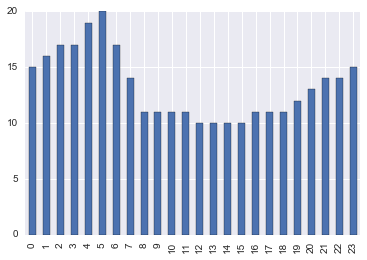

In [8]:
q2 = """SELECT
  HOUR(TIMESTAMP(trips_pickup_datetime)) AS hour,
  ROUND(AVG(trips_avg_mph)) AS speed
FROM
  [taxi_strava.joined_geohash_geonames]
WHERE
trips_avg_mph < 50
AND 0.1 < trips_trip_distance 
GROUP BY
  hour
ORDER BY
  hour;"""
df2 = pd.read_gbq(q2, project_id='bigquery-reddit-1003')
df2['speed'].plot(kind='bar')

In [9]:
df2

,hour,speed
0,0,15
1,1,16
2,2,17
3,3,17
4,4,19
5,5,20
6,6,17
7,7,14
8,8,11
9,9,11
